In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

2024-04-14 22:33:23.198591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 22:33:23.459749: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 22:33:24.467806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-14 22:33:24.467849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missi

In [4]:
import torch


In [6]:
torch.cuda.empty_cache()


In [7]:
import pandas as pd
test = pd.read_csv("NTC_SV_test.csv")
test = test.dropna()
df = pd.read_csv("NTC_SV_train.csv")
df = df.dropna()
print(df.head())
print(test.head())

   Unnamed: 0                                             review  label
0           0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1           1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2           2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3           3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4           4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
   Unnamed: 0                                             review  label
0           0  gửi xe trong toà nhà somerset thu trước mình đ...      1
1           1  sau khi xem review trên foody mình thấy các bạ...      0
2           2  ít món hải_sản không tươi positive chỉ có món ...      0
3           3  kết gà của popeyes lắm lắm không có chỗ nào ch...      1
4           4  bánh waffles bị negative ngọt quá thêm mứt với...      0


In [8]:
df.label

0        0
1        0
2        0
3        0
4        1
        ..
40756    0
40757    0
40758    0
40759    0
40760    0
Name: label, Length: 40760, dtype: int64

In [9]:
print(df['label'].value_counts())


label
1    20493
0    20267
Name: count, dtype: int64


label
1    20493
0    20267
Name: count, dtype: int64


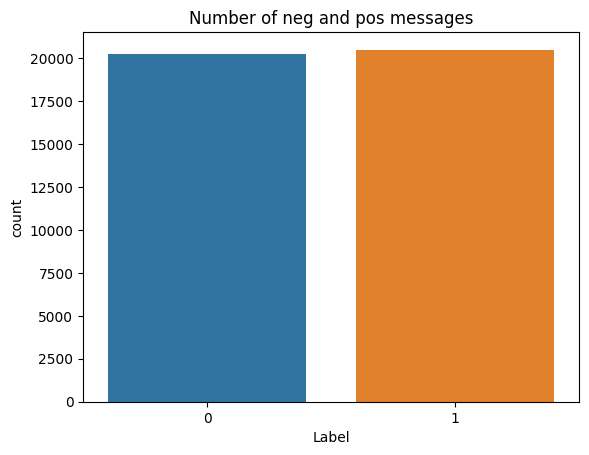

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the value counts of the label column
print(df['label'].value_counts())

# Plot the countplot
sns.countplot(x='label', data=df)
plt.xlabel('Label')
plt.title('Number of neg and pos messages')
plt.show()


In [12]:
data = df.review.tolist()
label = df.label.tolist()
data_test = test.review.tolist()
label_test = test.label.tolist()
data_n = []
for i in data:
  i = i.replace('_','')
  data_n.append(i)
test_v = []
for i in data_test:
  i = i.replace('_','')
  test_v.append(i)

In [13]:
import numpy as np

def load_fasttext_vec(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the first line, which contains metadata about the file
        first_line = file.readline()
        
        # Read each line of the file
        for line in file:
            values = line.strip().split()
            # The first value is the word
            word = values[0]
            # The remaining values are the vector
            vector = np.asarray(values[1:], dtype='float32')
            # Add word and vector to the dictionary
            embeddings_index[word] = vector
    return embeddings_index

# Specify the path to your FastText .vec file
fasttext_vec_file_path = 'cc.vi.300.vec_2'

# Load the embeddings from the .vec file
embeddings_index = load_fasttext_vec(fasttext_vec_file_path)

# Print an example vector for a specific word
example_word = 'từ'  # Change to any word you want to check
print(f'Vector for "{example_word}": {embeddings_index[example_word]}')


Vector for "từ": [ 4.2500e-02 -4.6700e-02 -1.4540e-01 -1.6430e-01 -3.1600e-02 -1.3670e-01
  2.8500e-02 -8.5700e-02  7.2200e-02  7.1000e-02  5.5200e-02 -6.2300e-02
 -2.6760e-01  1.0650e-01 -6.1400e-02 -1.3080e-01 -1.4800e-02  7.1900e-02
  1.3700e-02 -1.2000e-01  6.3800e-02 -9.5000e-03  1.3990e-01 -8.3000e-02
  2.8900e-02 -1.0660e-01  2.7020e-01  7.2600e-02  1.7790e-01 -9.5300e-02
 -1.5510e-01 -1.6900e-02 -9.1400e-02  1.1340e-01 -3.7200e-02 -9.1000e-03
 -7.7500e-02 -1.4700e-02  1.2000e-02  1.2900e-01  1.1730e-01  1.2790e-01
  1.6810e-01 -3.3000e-03 -2.1200e-02  5.3300e-02 -3.9400e-02 -3.6400e-02
  1.2520e-01  2.4300e-02  3.2100e-02  1.8040e-01  2.4940e-01 -1.7950e-01
  1.3090e-01  1.5120e-01  7.8000e-03  1.0310e-01 -6.6700e-02 -6.0800e-02
 -1.3900e-02  1.7340e-01 -1.8000e-03  2.9570e-01  1.2890e-01  1.2950e-01
 -1.0000e-01 -3.4600e-02 -5.7000e-03 -5.7000e-02 -5.1400e-02 -8.1000e-03
  3.4000e-02 -2.7690e-01 -1.1310e-01  4.7190e-01  1.4150e-01  5.9000e-03
 -1.7500e-02 -5.5700e-02  2.8100e-

In [14]:
import pickle

# Specify the path where you want to save the pickle file
pickle_file_path = 'embeddings_index_vi.pickle'  # Change this to your desired path

# Save the embeddings dictionary to a pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(embeddings_index, pickle_file)


In [15]:
import pickle
with open('embeddings_index_vi.pickle' , 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_n)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data_n)
# maxlen = max([len(i) for i in data_n])
maxlen = 300
data = pad_sequences(sequences, maxlen=maxlen)

le = LabelEncoder()

label = le.fit_transform(label)
labels = label.reshape(-1,1)
labels_test = le.fit_transform(label_test)
labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print('Shape of data tensor:', data.shape)
x_train,x_val,y_train,y_val = train_test_split(data,labels,test_size=0.15, random_state=48)

unique words : 38212
Shape of data tensor: (40760, 300)


In [17]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(300)
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

300
(38213, 300)


In [19]:
def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(len(word_index)+1,300,input_length=maxlen)(inputs)
    layer = LSTM(units=256)(layer)
    layer = Dense(256,activation = 'relu')(layer)
    layer = Dense(1,activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [20]:
from keras.callbacks import ModelCheckpoint

model = RNN()
checkpoint = ModelCheckpoint('weights_lstm_NCT_SV_fastext_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

2024-04-14 22:51:19.465755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 22:51:26.546105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-04-14 22:51:26.547566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9639 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-04-14 22:51:26.548847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/tas

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          11463900  
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 12,100,317
Trainable params: 12,100,317
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,verbose=1,
          callbacks=[checkpoint], validation_data=[x_val,y_val])

Epoch 1/10


2024-04-14 22:51:30.256456: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8904


271/271 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8447
Epoch 1: val_accuracy improved from -inf to 0.88420, saving model to weights_lstm_NCT_SV_fastext_sentece.hdf5
271/271 [==============================] - 13s 36ms/step - loss: 0.3545 - accuracy: 0.8447 - val_loss: 0.2884 - val_accuracy: 0.8842
Epoch 2/10
271/271 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9031
Epoch 2: val_accuracy improved from 0.88420 to 0.88600, saving model to weights_lstm_NCT_SV_fastext_sentece.hdf5
271/271 [==============================] - 11s 42ms/step - loss: 0.2471 - accuracy: 0.9031 - val_loss: 0.2852 - val_accuracy: 0.8860
Epoch 3/10
271/271 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9203
Epoch 3: val_accuracy did not improve from 0.88600
271/271 [==============================] - 8s 30ms/step - loss: 0.2095 - accuracy: 0.9203 - val_loss: 0.3014 - val_accuracy: 0.8803
Epoch 4/10
271/271 [==============================]

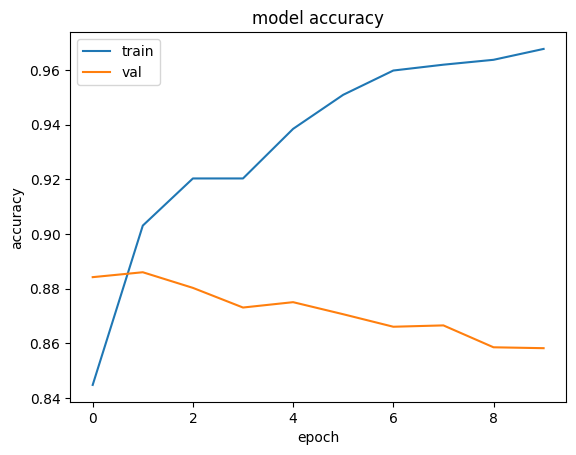

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

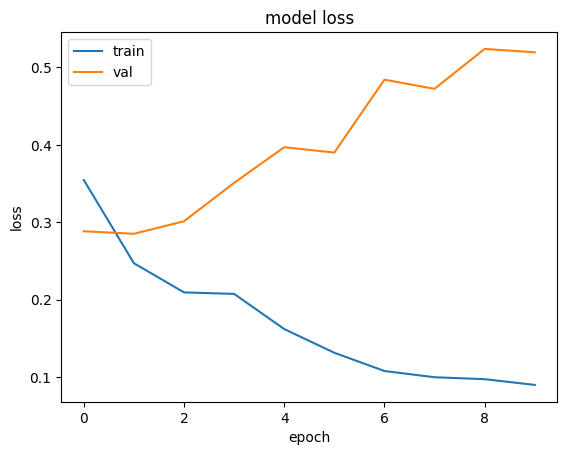

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from keras.models import load_model
#model = load_model('C:/Users/hari shivani gudi/Downloads/Test/weights_lstm_NCT_SV_fastext_sentece.hdf5')

In [25]:
from sklearn import metrics
acc = model.predict(convert_to_sequences(test_v))
accr = np.round(acc)
print(metrics.f1_score(labels_test, accr))
print(metrics.precision_score(labels_test, accr))
print(metrics.recall_score(labels_test, accr))

313/313 [==============================] - 3s 9ms/step
0.8711180124223602
0.8461538461538461
0.8976
